Analysis of Being taxi directions
=======

## Getting data and preparation
Data must be downloaded from https://www.microsoft.com/en-us/research/publication/t-drive-trajectory-data-sample/

To run the notebook the txt files need to be extracted to projects folder "data". Project structure would be:  
"data"  
taxi_analysis.ipynb

### Reference to Microsoft Research
[1] Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge from the physical world. In The 17th ACM SIGKDD international conference on Knowledge Discovery and Data mining, KDD’11, New York, NY, USA, 2011. ACM.

[2] Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. T-drive: driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International Conference on Advances in Geographic Information Systems, GIS ’10, pages 99-108, New York, NY, USA,2010. ACM.

In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data - change the path variable accordingly if data folder will be located somewhere else
path = './data/'
taxi_files = glob.glob(os.path.join(path, "*.txt"))   
column_names = ['taxi_id', 'date_time', 'longitude', 'latitude']
df = pd.concat(pd.read_csv(f, names=column_names) for f in taxi_files)
df['date_time'] = pd.to_datetime(df.date_time)

## Investigation of data

In [3]:
df.shape

(17662984, 4)

In [4]:
df.head(10)

,taxi_id,date_time,longitude,latitude
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248
5,1,2008-02-02 16:16:08,116.47217,39.92498
6,1,2008-02-02 16:26:08,116.47179,39.90718
7,1,2008-02-02 16:36:08,116.45617,39.90531
8,1,2008-02-02 17:00:24,116.47191,39.90577
9,1,2008-02-02 17:10:24,116.50661,39.91450


In [5]:
df.tail(10)

,taxi_id,date_time,longitude,latitude
1644,9999,2008-02-08 16:46:03,116.29429,39.98425
1645,9999,2008-02-08 16:51:05,116.28129,40.00061
1646,9999,2008-02-08 16:56:07,116.26561,40.00149
1647,9999,2008-02-08 17:01:09,116.24741,40.01014
1648,9999,2008-02-08 17:06:11,116.25519,40.00473
1649,9999,2008-02-08 17:11:13,116.27644,39.99720
1650,9999,2008-02-08 17:16:15,116.28298,39.99740
1651,9999,2008-02-08 17:21:17,116.28896,39.99235
1652,9999,2008-02-08 17:26:19,116.28925,39.98273
1653,9999,2008-02-08 17:36:23,116.26768,39.90663


From top 10 rows and last 10 rows one can see that first taxis sampling time is 10 minutes compared to last taxis 5 minutes. From taxi rides perspective during this 10 minutes the taxi could drop previous passengers, onboard news passengers and start a new ride. From the data its not that obvious how to detect such anomalies.
Lets investigate random taxi in the middle of data set to see how sampling times differ.

In [6]:
df[df.taxi_id == 5537].head(10)

,taxi_id,date_time,longitude,latitude
0,5537,2008-02-02 14:16:04,116.35099,40.01683
1,5537,2008-02-02 14:17:14,116.35476,40.01131
2,5537,2008-02-02 14:21:06,116.36858,39.98628
3,5537,2008-02-02 14:22:16,116.35846,39.98598
4,5537,2008-02-02 14:26:08,116.34806,39.97573
5,5537,2008-02-02 14:27:17,116.34804,39.97578
6,5537,2008-02-02 14:31:09,116.36328,39.98045
7,5537,2008-02-02 14:32:19,116.36366,39.97562
8,5537,2008-02-02 14:36:11,116.37281,39.96818
9,5537,2008-02-02 14:37:21,116.37143,39.96716


From taxi 5537 data we can see that even one taxi does not have a fixed sampling time, but can have a changing sampling time. For taxi 5537 it can be ~1 minute or ~4 minutes.

In [7]:
# lets drop rows where longitude and latitude are 0
df = df[df.longitude != 0]
df = df[df.latitude != 0]
df.shape

(17624358, 4)

## Sampling rate graphical representation
Lets try to repeat the charts demonstrate in papers under the reference section. For comparison lets plot time in minute and seconds.

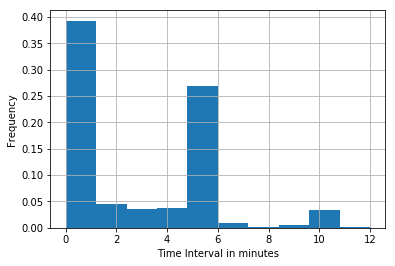

In [8]:
df_time_m = df['date_time'].diff().astype('timedelta64[m]')

df_time_m = df_time_m.hist(normed=True, range=(0,12))
df_time_m.set_ylabel("Frequency")
df_time_m.set_xlabel("Time Interval in minutes")
plt.show()

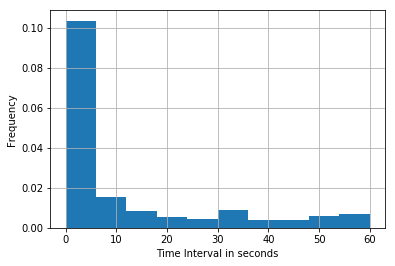

In [9]:
df_time_s = df['date_time'].diff().astype('timedelta64[s]')

df_time_s = df_time_s.hist(normed=True, range=(0,60))
df_time_s.set_ylabel("Frequency")
df_time_s.set_xlabel("Time Interval in seconds")
plt.show()

From the second intercal graph, one can see that the logic is similar. That most of the taxis with sampling time less then 1 minute, have a 1-5 second sampling rate.

## Sampling distance graphical representation
Lets try to repeat the distance graphics described in original Microsoft research papers.
Will use Haversine formula to calculate the distance between points described with longitudes and latitudes - https://en.wikipedia.org/wiki/Haversine_formula

In [10]:
def haversine_dist(lon1, lat1, lon2, lat2):
    r = 0.0174533  # 1 degree in radians
    return 2 * 6371000 * np.arcsin( np.sqrt(np.sin(r*(lat2 - lat1)/2.0)**2 + np.cos(r*lat1) * np.cos(r*lat2) * np.sin(r*(lon2 - lon1)/2.0)**2))

In [11]:
df['prev_taxi_id'] = df.taxi_id.shift()
df['is_same_taxi'] = (df['taxi_id'] == df['prev_taxi_id'])
df['dist'] = haversine_dist(df.longitude,df.latitude, df.longitude.shift(),df.latitude.shift()) # use shifted longitude and latitude columns for distance
df.loc[df['is_same_taxi'] == False, 'dist'] = 0 # set 0 to all distance where taxi id has changed
df.head(10)

,taxi_id,date_time,longitude,latitude,prev_taxi_id,is_same_taxi,dist
0,1,2008-02-02 15:36:08,116.51172,39.92123,NaN,False,0.000000
1,1,2008-02-02 15:46:08,116.51135,39.93883,1,True,1957.285829
2,1,2008-02-02 15:46:08,116.51135,39.93883,1,True,0.000000
3,1,2008-02-02 15:56:08,116.51627,39.91034,1,True,3195.605746
4,1,2008-02-02 16:06:08,116.47186,39.91248,1,True,3795.226361
5,1,2008-02-02 16:16:08,116.47217,39.92498,1,True,1390.188581
6,1,2008-02-02 16:26:08,116.47179,39.90718,1,True,1979.535848
7,1,2008-02-02 16:36:08,116.45617,39.90531,1,True,1348.469167
8,1,2008-02-02 17:00:24,116.47191,39.90577,1,True,1343.564368
9,1,2008-02-02 17:10:24,116.50661,39.91450,1,True,3114.771273


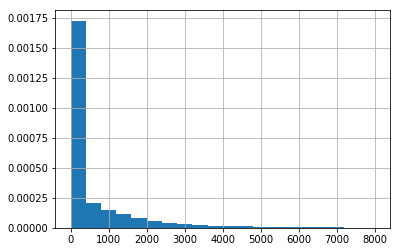

In [12]:
df.dist.hist(range=(0,8000), normed=True, bins=20)
plt.show()

Graph demonstrates that even though time intervals maybe quite long then the distance travelled during the interval may not be that much. This can occur due to multiple reasons - some taxis just stand, traffic conditions change depending on the time of the day (rush hour and other times)

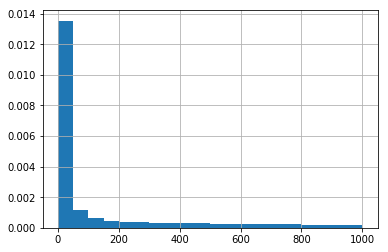

In [13]:
# lets investigate the chart up to 1km
df.dist.hist(range=(0,1000), normed=True, bins=20)
plt.show()

## Visualization of taxi routes
Repeat the taxi route visualization described in Microsoft papers.

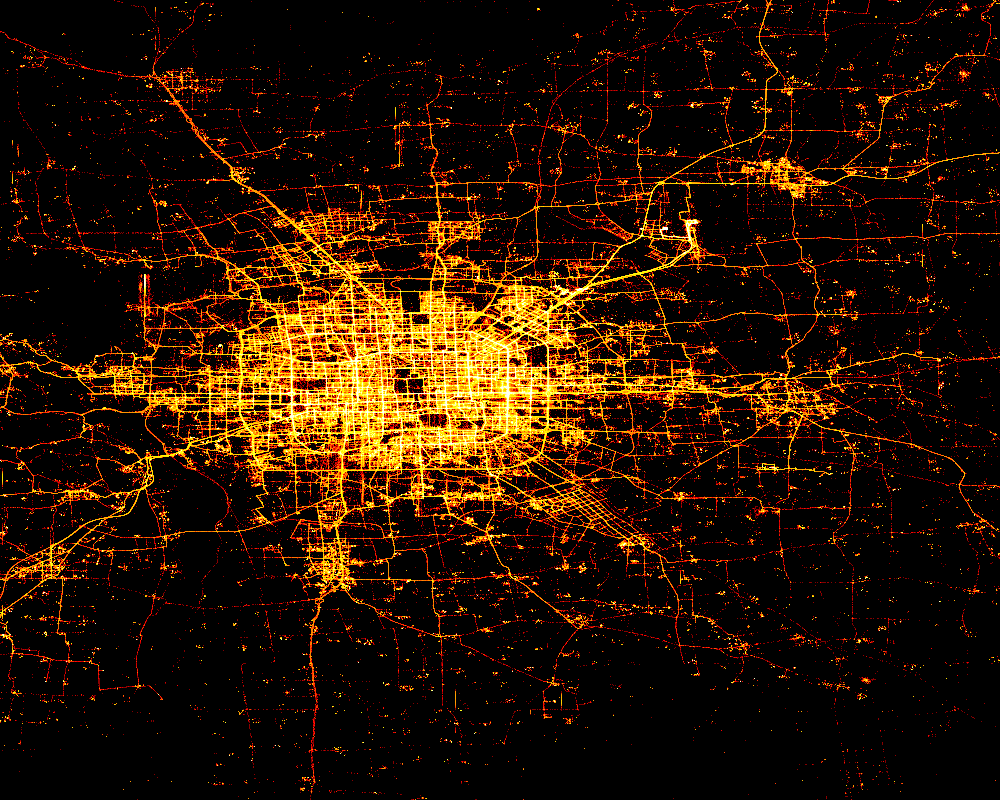

In [14]:
# Limit the Beijing window out of dataset
xmin, xmax = 116.1, 116.8
ymin, ymax = 39.5, 40.3

window = df[(xmin < df.longitude) & (df.longitude < xmax) & \
            (ymin < df.latitude) & (df.latitude < ymax)]
background = "black"
export = partial(export_image, export_path="export", background=background)

cvs = ds.Canvas(plot_width=1000, plot_height=800)
agg = cvs.points(window, 'longitude', 'latitude')
export(tf.shade(agg, cmap = Hot, how='eq_hist'), "bejing_taxi")

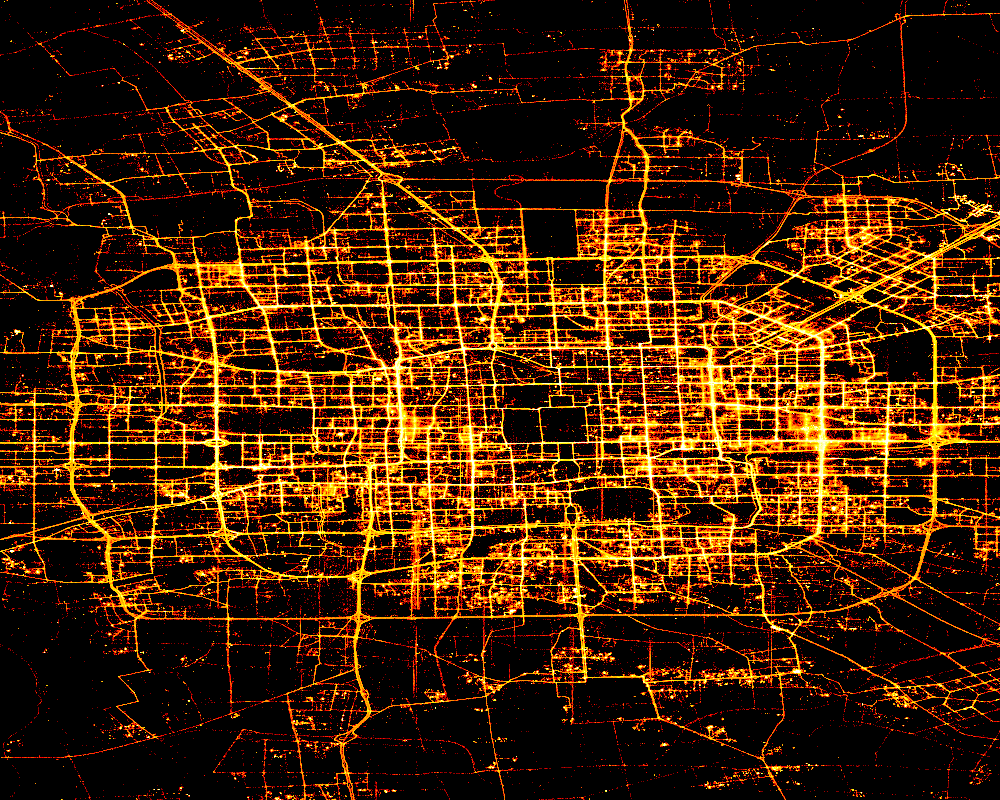

In [15]:
# Limit the Beijing window out of dataset
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = df[(xmin < df.longitude) & (df.longitude < xmax) & \
            (ymin < df.latitude) & (df.latitude < ymax)]
background = "black"
export = partial(export_image, export_path="export", background=background)

cvs = ds.Canvas(plot_width=1000, plot_height=800)
agg = cvs.points(window, 'longitude', 'latitude')
export(tf.shade(agg, cmap = Hot, how='eq_hist'), "bejing_5th_ring_taxi")

### Descriptive statistics about taxis
Previously we have found out how data was sampled and how taxi routes look like.

Now its time to investigate their travels distance wise.

In [16]:
# calculate much is the duration and the speed
# 50 km/h is around 13.9 m/s

df['duration'] = df['date_time'].diff().astype('timedelta64[s]')
df.loc[df['is_same_taxi'] == False, 'duration'] = 0
df.loc[df['duration'] == np.nan, 'duration'] = 0
df.head(10)

,taxi_id,date_time,longitude,latitude,prev_taxi_id,is_same_taxi,dist,duration
0,1,2008-02-02 15:36:08,116.51172,39.92123,NaN,False,0.000000,0.0
1,1,2008-02-02 15:46:08,116.51135,39.93883,1,True,1957.285829,600.0
2,1,2008-02-02 15:46:08,116.51135,39.93883,1,True,0.000000,0.0
3,1,2008-02-02 15:56:08,116.51627,39.91034,1,True,3195.605746,600.0
4,1,2008-02-02 16:06:08,116.47186,39.91248,1,True,3795.226361,600.0
5,1,2008-02-02 16:16:08,116.47217,39.92498,1,True,1390.188581,600.0
6,1,2008-02-02 16:26:08,116.47179,39.90718,1,True,1979.535848,600.0
7,1,2008-02-02 16:36:08,116.45617,39.90531,1,True,1348.469167,600.0
8,1,2008-02-02 17:00:24,116.47191,39.90577,1,True,1343.564368,1456.0
9,1,2008-02-02 17:10:24,116.50661,39.91450,1,True,3114.771273,600.0


In [17]:
# lets calculate the speed between distance-s
# first lets drop all rows where duration is 0 as it means that taxi has not moved at all
df = df[df.duration != 0]
df['speed'] = df['dist']/df['duration']
df.head(10)

,taxi_id,date_time,longitude,latitude,prev_taxi_id,is_same_taxi,dist,duration,speed
1,1,2008-02-02 15:46:08,116.51135,39.93883,1,True,1957.285829,600.0,3.262143
3,1,2008-02-02 15:56:08,116.51627,39.91034,1,True,3195.605746,600.0,5.326010
4,1,2008-02-02 16:06:08,116.47186,39.91248,1,True,3795.226361,600.0,6.325377
5,1,2008-02-02 16:16:08,116.47217,39.92498,1,True,1390.188581,600.0,2.316981
6,1,2008-02-02 16:26:08,116.47179,39.90718,1,True,1979.535848,600.0,3.299226
7,1,2008-02-02 16:36:08,116.45617,39.90531,1,True,1348.469167,600.0,2.247449
8,1,2008-02-02 17:00:24,116.47191,39.90577,1,True,1343.564368,1456.0,0.922778
9,1,2008-02-02 17:10:24,116.50661,39.91450,1,True,3114.771273,600.0,5.191285
10,1,2008-02-02 20:30:34,116.49625,39.91460,1,True,883.640927,12010.0,0.073575
11,1,2008-02-02 20:40:33,116.50962,39.91071,1,True,1219.597493,599.0,2.036056


In [18]:
# Print out how many points where passed with more then 100 km/h to detect anomalies
# 100 km/h is ~ 28 m/s
df[df.speed > 28]

,taxi_id,date_time,longitude,latitude,prev_taxi_id,is_same_taxi,dist,duration,speed
546,10,2008-02-03 11:14:07,116.34733,39.97575,10,True,353.487192,10.0,35.348719
754,10,2008-02-03 13:44:57,116.38378,39.94130,10,True,2940.210006,8.0,367.526251
756,10,2008-02-03 13:45:46,116.34932,39.93805,10,True,2960.046698,49.0,60.409116
1583,10,2008-02-04 07:03:30,116.39953,39.91608,10,True,103.711614,3.0,34.570538
1681,10,2008-02-04 10:12:28,116.35677,39.87637,10,True,95.149928,3.0,31.716643
2565,10,2008-02-05 06:56:22,116.39885,39.91360,10,True,109.533685,3.0,36.511228
2595,10,2008-02-05 07:03:44,116.40153,39.91493,10,True,413.843874,4.0,103.460969
3427,10,2008-02-06 06:52:42,116.39802,39.90680,10,True,228.289680,4.0,57.072420
3428,10,2008-02-06 06:52:45,116.39765,39.90495,10,True,208.117595,3.0,69.372532
3429,10,2008-02-06 06:53:05,116.39595,39.89613,10,True,991.403190,20.0,49.570160


117739 rows have a speed which is bigger then 100 km/h. Lets drop these as they are probably coming from a measurement error of coordinates.

In [19]:
df = df[df.speed < 28]

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # remove scientific notation
df['date'] = df['date_time'].dt.date
df['hour'] = df['date_time'].dt.hour
df.head(10)

,taxi_id,date_time,longitude,latitude,prev_taxi_id,is_same_taxi,dist,duration,speed,date,hour
1,1,2008-02-02 15:46:08,116.511,39.939,1,True,1957.286,600.000,3.262,2008-02-02,15
3,1,2008-02-02 15:56:08,116.516,39.910,1,True,3195.606,600.000,5.326,2008-02-02,15
4,1,2008-02-02 16:06:08,116.472,39.912,1,True,3795.226,600.000,6.325,2008-02-02,16
5,1,2008-02-02 16:16:08,116.472,39.925,1,True,1390.189,600.000,2.317,2008-02-02,16
6,1,2008-02-02 16:26:08,116.472,39.907,1,True,1979.536,600.000,3.299,2008-02-02,16
7,1,2008-02-02 16:36:08,116.456,39.905,1,True,1348.469,600.000,2.247,2008-02-02,16
8,1,2008-02-02 17:00:24,116.472,39.906,1,True,1343.564,1456.000,0.923,2008-02-02,17
9,1,2008-02-02 17:10:24,116.507,39.914,1,True,3114.771,600.000,5.191,2008-02-02,17
10,1,2008-02-02 20:30:34,116.496,39.915,1,True,883.641,12010.000,0.074,2008-02-02,20
11,1,2008-02-02 20:40:33,116.510,39.911,1,True,1219.597,599.000,2.036,2008-02-02,20


In [21]:
# calculate total travelled distance per day over all of the taxis
df_travel_days = df.groupby(['date'])['dist'].sum().reset_index(name ='dist')
df_travel_days.head(10)

,date,dist
0,2008-02-02,1099918931.430
1,2008-02-03,2097379011.922
2,2008-02-04,2082281359.055
3,2008-02-05,1973670335.316
4,2008-02-06,1453882928.069
5,2008-02-07,1220990907.756
6,2008-02-08,918966979.649


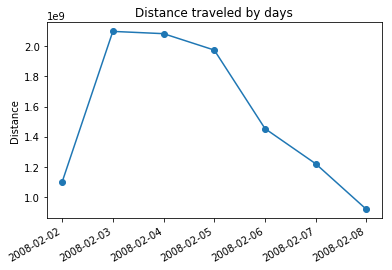

In [22]:
# Plot the distance for easier analysis
fig, ax = plt.subplots()
ax.plot_date(x=df_travel_days['date'], y=df_travel_days['dist'], linestyle="-")
fig.autofmt_xdate()
plt.title("Distance traveled by days")
plt.ylabel("Distance")
plt.show()

Data covers the dates from Saturday 02.02.2008 to Saturday 08.02.2008.
From the figure we see that Saturdays have less travel, but that comes from the issue that data is partial for Saturdays.
Rapid decline of travel starting from 06.02.2008 probably comes from the fact that these days had more erronous data that was removed.  
Lets investigate what times during the day are more busier then others.

In [23]:
df_travel_days_hours = df.groupby(['date', 'hour'])['dist'].sum().reset_index(name ='dist')
df_travel_days_hours['date'] = pd.to_datetime(df_travel_days_hours.date)
df_travel_days_hours.head(10)

,date,hour,dist
0,2008-02-02,13,35005045.693
1,2008-02-02,14,103061395.204
2,2008-02-02,15,104092714.678
3,2008-02-02,16,105877330.257
4,2008-02-02,17,107878014.882
5,2008-02-02,18,111584483.860
6,2008-02-02,19,107326921.972
7,2008-02-02,20,105756959.047
8,2008-02-02,21,108936927.738
9,2008-02-02,22,106883739.357


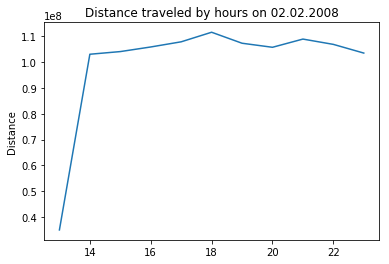

In [24]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-02']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 02.02.2008")
plt.ylabel("Distance")
plt.show()

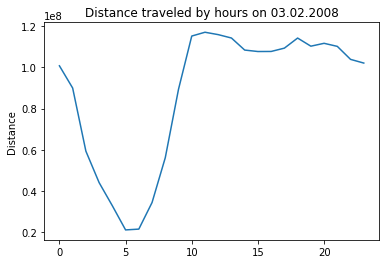

In [25]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-03']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 03.02.2008")
plt.ylabel("Distance")
plt.show()

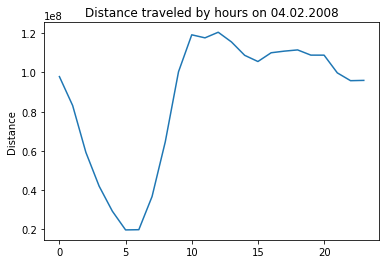

In [26]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-04']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 04.02.2008")
plt.ylabel("Distance")
plt.show()

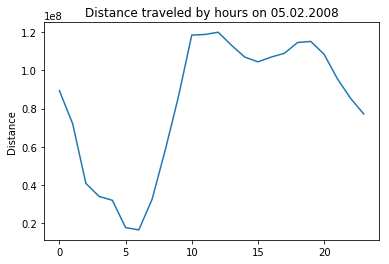

In [27]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-05']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 05.02.2008")
plt.ylabel("Distance")
plt.show()

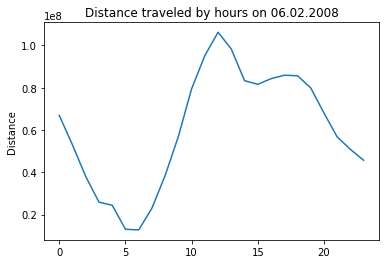

In [28]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-06']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 06.02.2008")
plt.ylabel("Distance")
plt.show()

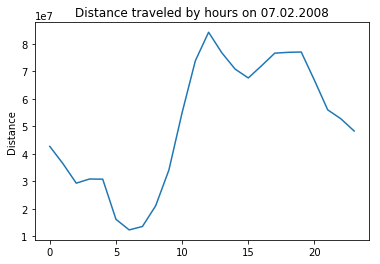

In [29]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-07']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 07.02.2008")
plt.ylabel("Distance")
plt.show()

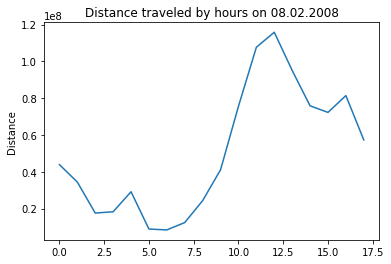

In [30]:
df_to_plot = df_travel_days_hours[df_travel_days_hours['date'] == '2008-02-08']
plt.plot(df_to_plot['hour'], df_to_plot['dist'])
plt.title("Distance traveled by hours on 08.02.2008")
plt.ylabel("Distance")
plt.show()

During business days a clear pattern emerges - most of travels are done during 9 AM to 5 PM. Which makes sense as business people are mostly travelling during that time.

Lets also look how taxis performed on a single taxi level.

In [31]:
# calculate total travelled distance per taxi
df_taxis = df.groupby(['taxi_id'])['dist'].sum().reset_index(name ='dist')

In [32]:
df_taxis = df_taxis.sort_values(by=['dist'], ascending=False)

In [33]:
# Lets print out taxis with the biggest mileage
df_taxis.head(10)

,taxi_id,dist
1266,1277,3589371.337
4249,4284,3436370.356
5317,5353,3318530.393
2950,2973,3249634.787
2512,2531,3172281.486
5200,5236,3106660.224
7087,7143,3082169.482
798,805,3041172.720
5210,5246,2966533.376
6017,6063,2965306.166


In [34]:
# Lets print total taxis with 0 mileage
df_taxis[df_taxis.dist == 0]

,taxi_id,dist
5608,5647,0.000
7795,7862,0.000
7292,7350,0.000
5562,5600,0.000
862,869,0.000
6028,6074,0.000
7798,7865,0.000
2466,2484,0.000
8826,8906,0.000
6971,7027,0.000
